In [1]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
deaths = pd.read_csv("../05_cleaned_data/deaths_wa.csv")

In [3]:
deaths["StateName"].value_counts()

Washington    570
Oregon        469
Montana       421
Idaho         366
Wyoming       195
Nevada        190
Name: StateName, dtype: int64

In [4]:
deaths.columns

Index(['County', 'County Code', 'Year', 'Year Code',
       'Drug/Alcohol Induced Cause', 'Drug/Alcohol Induced Cause Code',
       'Deaths', 'State', 'StateFIPS', 'CountyName', 'StateName', 'CountyFIPS',
       'StateAbbr', 'STATE_COUNTY', 'state_abbrev', 'FIP_unique', 'Population',
       'county_test'],
      dtype='object')

In [5]:
deaths["Drug/Alcohol Induced Cause"].unique()

array(['Drug poisonings (overdose) Unintentional (X40-X44)',
       'Drug poisonings (overdose) Suicide (X60-X64)',
       'All other alcohol-induced causes',
       'All other non-drug and non-alcohol causes',
       'Drug poisonings (overdose) Undetermined (Y10-Y14)',
       'All other drug-induced causes',
       'Alcohol poisonings (overdose) (X45, X65, Y15)'], dtype=object)

In [6]:
washington = deaths[deaths["StateName"] == "Washington"]
comp = deaths[deaths["StateName"] != "Washington"]

In [7]:
wa_deaths = washington.copy()
comp_deaths = comp.copy()

In [8]:
overdose_list = ['Drug poisonings (overdose) Unintentional (X40-X44)',
       'Drug poisonings (overdose) Suicide (X60-X64)',
       'Drug poisonings (overdose) Undetermined (Y10-Y14)',
       'Alcohol poisonings (overdose) (X45, X65, Y15)']

In [9]:
wa_deaths["overdose"] = 0
comp_deaths["overdose"] = 0

In [10]:
wa_deaths.loc[wa_deaths["Drug/Alcohol Induced Cause"].isin(overdose_list), "overdose"] = 1
comp_deaths.loc[comp_deaths["Drug/Alcohol Induced Cause"].isin(overdose_list), "overdose"] = 1

In [11]:
wa_deaths = wa_deaths[wa_deaths["overdose"] == 1]
comp_deaths = comp_deaths[comp_deaths["overdose"] == 1]

In [12]:
wa_deaths["overdose_per_100k"] = wa_deaths["Deaths"] / wa_deaths["Population"] * 100_000
comp_deaths["overdose_per_100k"] = comp_deaths["Deaths"] / comp_deaths["Population"] * 100_000

In [13]:
wa_result = wa_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
comp_result = comp_deaths.groupby(["Year", "StateName", "CountyName"])["overdose_per_100k"].sum().reset_index()

In [14]:
wa_stats = wa_deaths.groupby(["Year"])["overdose_per_100k"].mean().reset_index()
comp_stats = comp_deaths.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [ ]:
wa_res = pd.DataFrame(wa_stats.describe()["overdose_per_100k"]).rename(columns={"overdose_per_100k": "Overdoses per 100k Residents - Washington"})
comp_res = pd.DataFrame(comp_stats.describe()["overdose_per_100k"]).rename(columns={"overdose_per_100k": "Overdoses per 100k Residents - Comp States"})
stats = pd.concat([wa_res, comp_res], axis=1)
stats

In [43]:
# saved original code for plotting
wa_deaths.groupby("Year")["overdose_per_100k"].agg([np.mean, np.std])

wa_deaths_b4 = wa_deaths[wa_deaths["Year"] < 2012]
wa_deaths_after = wa_deaths[wa_deaths["Year"] >= 2012]

source_data = wa_deaths_b4

plot_wa_b4 = alt.Chart(source_data).mark_point().encode(
    y=alt.Y("mean_overdose:Q", scale=alt.Scale(zero=False)),
    x=alt.X("Year:O", scale=alt.Scale(zero=False))
).transform_aggregate(
    mean_overdose='mean(overdose_per_100k)',
    groupby=["Year"]
)

plot_wa_b4

fit_wa_b4 = plot_wa_b4.transform_regression('Year', 'mean_overdose',method="linear"
).mark_line()

fit_wa_b4

source_data = wa_deaths_after

plot_wa_after = alt.Chart(source_data).mark_point().encode(
    y=alt.Y("mean_overdose:Q", scale=alt.Scale(zero=False)),
    x=alt.X("Year:O", scale=alt.Scale(zero=False))
).transform_aggregate(
    mean_overdose='mean(overdose_per_100k)',
    groupby=["Year"]
)

plot_wa_after

fit_wa_after = plot_wa_after.transform_regression('Year', 'mean_overdose',method="linear"
).mark_line()

fit_wa_after

plot_wa_b4 + fit_wa_b4 + plot_wa_after + fit_wa_after

alt.LayerChart(...)

In [19]:
# create a scale for number of years before and after 2007 (target year)

def scale_years(year):
    if year == 2009:
        return -3
    if year == 2010:
        return -2
    if year == 2011:
        return -1
    if year == 2012:
        return 0
    if year == 2013:
        return 1
    if year == 2014:
        return 2
    if year == 2015:
        return 3

wa_stats["year relative to policy"] = wa_stats["Year"].apply(lambda x: scale_years(x))
# comp_result["year relative to policy"] = comp_result["Year"].apply(lambda x: scale_years(x))

# double check no nulls in "year relative to policy"

assert (wa_stats["year relative to policy"].isnull().sum() == 0)
# assert (comp_result["year relative to policy"].isnull().sum() == 0)

# doing this in case the float == int comparison causes issues

In [25]:
# split into before 2007 and after 2007

wa_b4 = wa_stats[wa_stats["Year"] < 2012]
wa_after = wa_stats[wa_stats["Year"] > 2012]


# wa_after = wa_after[wa_after["Year"] != 2007] # may need to handle this differently

In [26]:
from sklearn.linear_model import LinearRegression 

regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(wa_b4["year relative to policy"]).reshape(-1, 1)
y_b4 = np.array(wa_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(wa_after["year relative to policy"]).reshape(-1, 1)
y_after = np.array(wa_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_b4)

In [27]:
y_pred_b4

array([[10.75801182],
       [10.07507609],
       [ 9.39214037]])

In [28]:
y_pred_after

array([[6.92152372],
       [7.54968398],
       [8.17784423]])

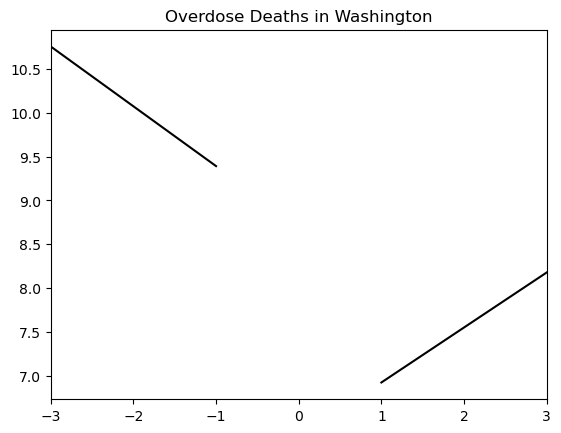

In [29]:
plt.xlim(-3, 3)
#plt.ylim(0, 500)

plt.title("Overdose Deaths in Washington")

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')

# plot avg value in each year

In [30]:
x = "Year"
y = "overdose_per_100k"

In [31]:
def vertical_line(year):
    """Function to plot a vertical line at year of policy implementation"""
    line = alt.Chart(pd.DataFrame({
    'Date': [year],
    'color': ["black"]
    })).mark_rule().encode(
    x='Date:Q', # use q for "quantitative" - as per altair docs
    color=alt.Color('color:N', scale=None)
    )

    return line

In [32]:
# test function
line = vertical_line(2004)

In [33]:
def get_charts(b4, after, title_b4, title_after):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4)
        
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_after)
    )

    return base_before, base_after

In [35]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = wa_b4, after = wa_after, title_b4 = "deaths before policy", title_after="deaths after policy")
base_before + base_after

alt.LayerChart(...)

In [37]:
# starting here in final report
# no longer calculating base chart above - just adding in regression line at same time
def get_preds(df, x, y):

    # init new empty df for our predictions
    predictions = pd.DataFrame()

    # fit our model and predict values
    model = smf.ols(f"{y} ~ {x}", data=df).fit()
    model_predict = model.get_prediction(df[x])

    # save predictions back to df, calculate confidence intervals
    predictions["overdose_per_100k"] = model.predict(df[x])
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=0.05)

    # save original year columns to new predictions df
    predictions["Year"] = df["Year"]
    predictions["year relative to policy"] = df["year relative to policy"]
    return predictions

In [39]:
wa_b4_preds = get_preds(wa_b4, x, y)
wa_after_preds = get_preds(wa_after, x, y)

In [40]:
def get_charts(b4, after, title_b4, title_after, color):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4).transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value(color))
        
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("year relative to policy", scale=alt.Scale(zero=False)),
            
        )
        .properties(title=title_after).transform_regression("year relative to policy", "overdose_per_100k")
    .mark_line()
    .encode(color=alt.value(color))
    )

    return base_before, base_after

In [41]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = wa_b4_preds, after = wa_after_preds, title_b4 = "Deaths Before Policy Implementation", title_after="Deaths After Policy Implementation", color="red")
base_before + base_after

alt.LayerChart(...)